<a href="https://colab.research.google.com/github/tikhantonina/ml_projects/blob/main/%5Bhomework%5Ddense_and_convolutional_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [ ]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

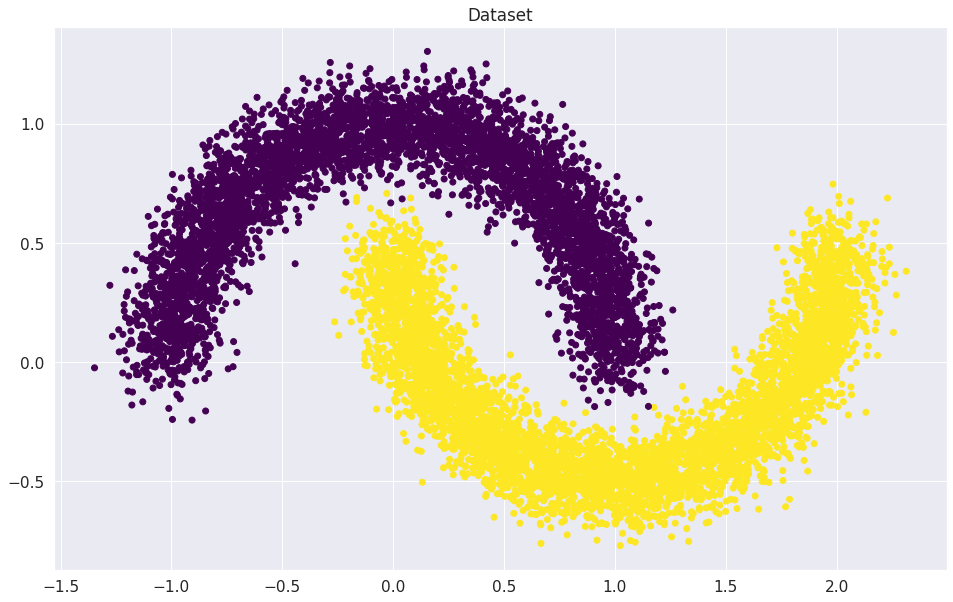

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.LongTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.LongTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        # self.in_features = in_features
        # self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x@self.weights.T 
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [ ]:
# my = LinearRegression(20,10)
# a = torch.randn(5,20)
# my(a)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [ ]:
pip install torchinfo

In [ ]:
from torchinfo import summary

summary(linear_regression, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

3 параметра

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp, y_batch[:, None].type_as(torch.FloatTensor())) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  linear_regression.forward(X_batch) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.21875
Iteration: 100
Batch accuracy: 0.6171875
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.8125
Iteration: 400
Batch accuracy: 0.8359375
Iteration: 500
Batch accuracy: 0.890625
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.78125
Iteration: 800
Batch accuracy: 0.8046875

Iteration: 873.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 8

### Визуализируем результаты

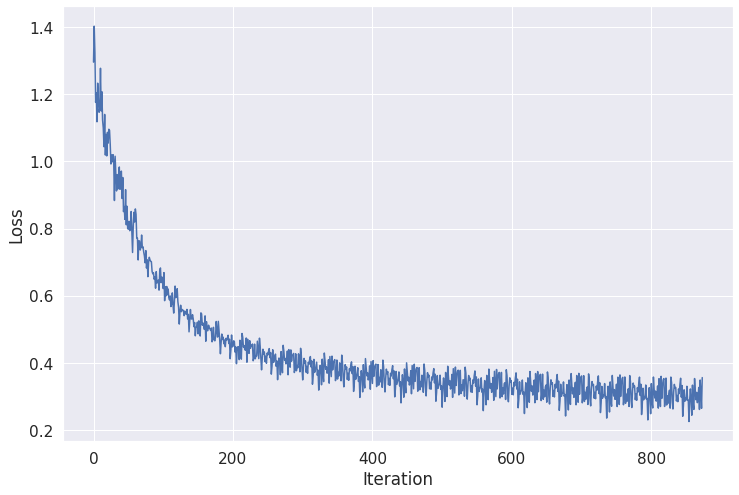

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

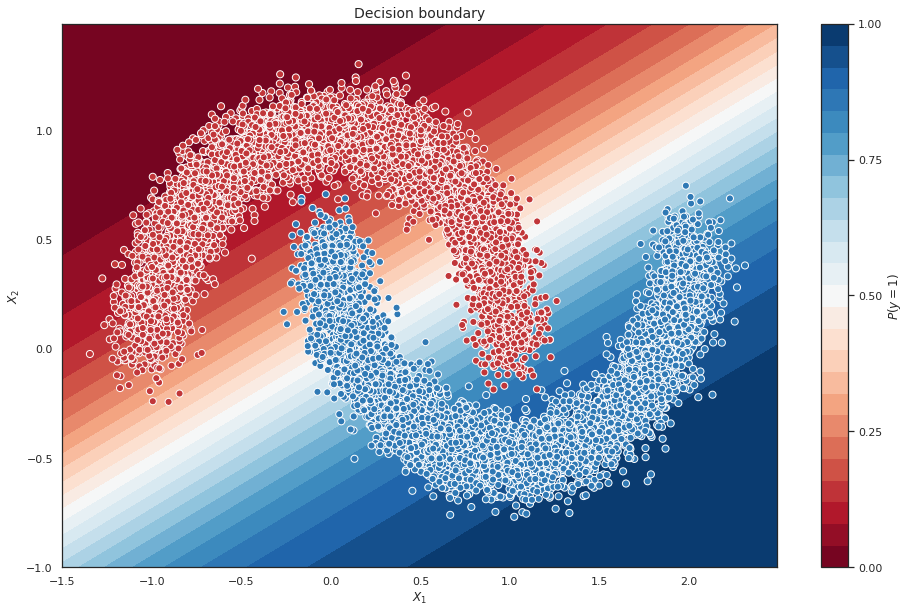

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        probabilities =  linear_regression.forward(x_batch)
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        # batch_acc = (preds.flatten() == _).type(torch.float32).sum() / _.size(0)
        # print(batch_acc)
    return predictions.flatten()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, predict(val_dataloader, linear_regression))
# YOUR CODE. Compute total accuracy

0.8668

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8668

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [ ]:
import torch
import torchvision
from torchvision import transforms as tfs
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import os
from torchvision.datasets import MNIST

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 256

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader =   DataLoader(val_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [ ]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [ ]:
activation = nn.ELU
features = 784
classes = 10 
model = nn.Sequential(
    
    nn.Flatten(),
    nn.Linear(features, 128),
    nn.ELU(),
    nn.ELU(),
    nn.Linear(128, 10),
    #YOUR CODE. Add layers to your sequential class
)
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): ELU(alpha=1.0)
  (4): Linear(in_features=128, out_features=10, bias=True)
)

In [ ]:
summary(model
        , (features,)
        , batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [256, 784]               0
            Linear-2                 [256, 128]         100,480
               ELU-3                 [256, 128]               0
               ELU-4                 [256, 128]               0
            Linear-5                  [256, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 2.30
Params size (MB): 0.39
Estimated Total Size (MB): 3.45
----------------------------------------------------------------


In [ ]:
criterion = nn.CrossEntropyLoss()  #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [ ]:
max_epochs = 10
history = []
accuracy = {"train": [], "valid": []}
all = 0
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              # x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
              outp = model(x_batch.to(device))
              optimizer.zero_grad()
            else:
              model.eval()
              outp = model(x_batch.to(device))
            preds = outp.argmax(-1) # torch.argmax(model(x_batch), dim=1)
            correct = (preds==y_batch.to(device)).cpu().numpy().mean()
            all = 1 
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                history.append(loss.item())
                loss.backward()
                optimizer.step()
                # YOUR CODE. Calculate gradients and make a step of your optimizer
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    print(f'{epoch+1},\t loss: {history[-1]}')

Epoch: 1
Loader: train. Accuracy: 0.8543502938034188
Loader: valid. Accuracy: 0.9036458333333334
1,	 loss: 0.36131715774536133
Epoch: 2
Loader: train. Accuracy: 0.9155148237179487
Loader: valid. Accuracy: 0.9273838141025641
2,	 loss: 0.32718488574028015
Epoch: 3
Loader: train. Accuracy: 0.9357805822649573
Loader: valid. Accuracy: 0.9452123397435898
3,	 loss: 0.29669904708862305
Epoch: 4
Loader: train. Accuracy: 0.9496861645299145
Loader: valid. Accuracy: 0.9541266025641025
4,	 loss: 0.2696058452129364
Epoch: 5
Loader: train. Accuracy: 0.9588007478632479
Loader: valid. Accuracy: 0.9597355769230769
5,	 loss: 0.24932515621185303
Epoch: 6
Loader: train. Accuracy: 0.9655114850427351
Loader: valid. Accuracy: 0.9611378205128205
6,	 loss: 0.23065046966075897
Epoch: 7
Loader: train. Accuracy: 0.9702690972222222
Loader: valid. Accuracy: 0.9624399038461539
7,	 loss: 0.21184827387332916
Epoch: 8
Loader: train. Accuracy: 0.9746427617521367
Loader: valid. Accuracy: 0.964042467948718
8,	 loss: 0.1944

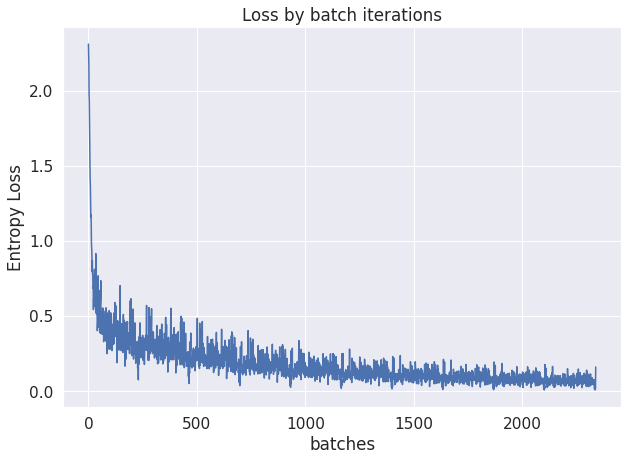

In [ ]:
plt.figure(figsize=(10, 7))

plt.plot(history)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [ ]:
elu_accuracy = accuracy["valid"]

In [ ]:
# YOUR CODE. Do the same thing with other activations 
# (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(features, 128),
      activation,
      activation,
      nn.Linear(128, 10),
  )
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  max_epochs = 10
  history = []
  accuracy = {"train": [], "valid": []}
  all = 0
  for epoch in range(max_epochs):
      for k, dataloader in loaders.items():
          epoch_correct = 0
          epoch_all = 0
          for x_batch, y_batch in dataloader:
              if k == "train":
                outp = model(x_batch.to(device))
                optimizer.zero_grad()
              else:
                model.eval()
                outp = model(x_batch.to(device))
              preds = outp.argmax(-1)
              correct = (preds==y_batch.to(device)).cpu().numpy().mean()
              epoch_correct += correct.item()
              epoch_all += 1
              if k == "train":
                  loss = criterion(outp, y_batch.to(device))
                  history.append(loss.item())
                  loss.backward()
                  optimizer.step()
          # print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
          accuracy[k].append(epoch_correct/epoch_all)
      # print(f'{epoch+1},\t loss: {history[-1]}')
  return accuracy['valid']

In [ ]:
plain_accuracy = test_activation_function(Identical())
relu_accuracy = test_activation_function(nn.ReLU())
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU())
elu_accuracy = test_activation_function(nn.ELU())

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

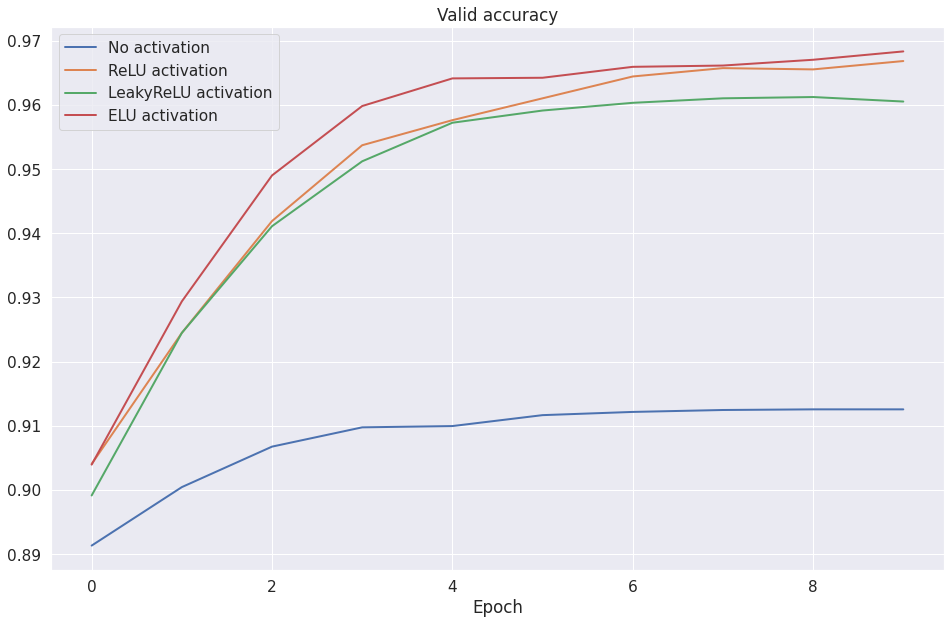

In [ ]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-03-18 08:05:35--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-03-18 08:05:36--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   118KB/s    in 0.4s    

2022-03-18 08:05:38 (118 KB/s) - ‘sample_photo.jpg’ saved [49337/4

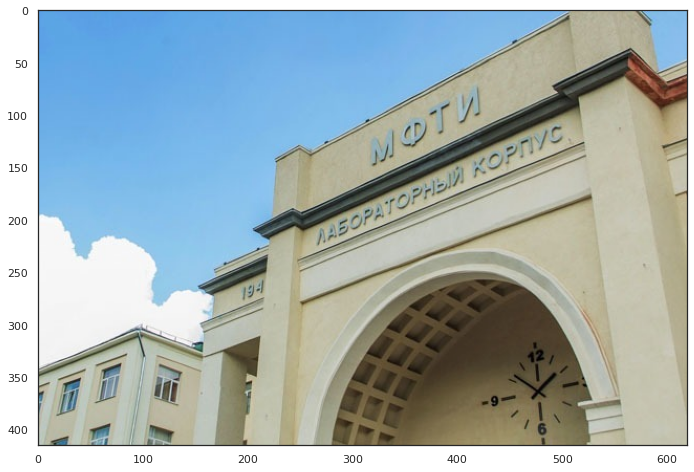

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
  [0.0625, 0.125, 0.0625],
  [0.125, 0.25, 0.125],
  [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

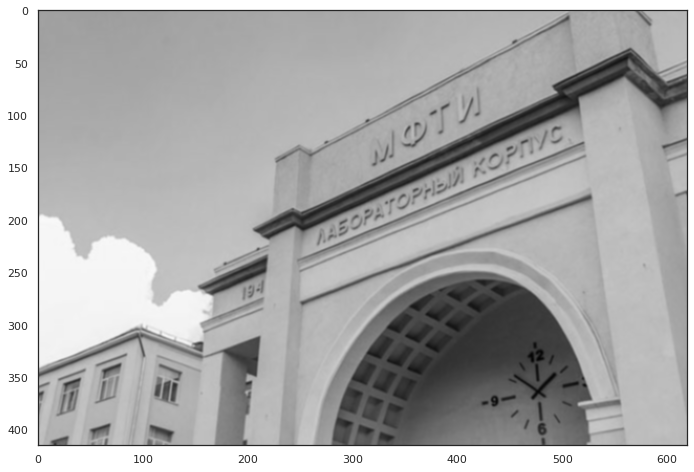

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие E

2) Увеличение резкости Д

3) Тождественное преобразование A

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2) 
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Flatten() 
        self.fc2 = nn.Sequential(
          nn.Linear(400, 120),
          nn.ReLU(),
          nn.Linear(120, 84),
          nn.ReLU(),
          nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        # print(x.shape)
        x = self.fc2(x)
        return x

In [ ]:
model = LeNet().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()  #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [ ]:
summary(model.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 26, 26]              60
         MaxPool2d-2            [-1, 6, 13, 13]               0
            Conv2d-3           [-1, 16, 11, 11]             880
         MaxPool2d-4             [-1, 16, 5, 5]               0
           Flatten-5                  [-1, 400]               0
            Linear-6                  [-1, 120]          48,120
              ReLU-7                  [-1, 120]               0
            Linear-8                   [-1, 84]          10,164
              ReLU-9                   [-1, 84]               0
           Linear-10                   [-1, 10]             850
Total params: 60,074
Trainable params: 60,074
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Tot

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [ ]:
max_epochs = 10
history = []
accuracy = {"train": [], "valid": []}
all = 0
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              outp = model(x_batch.to(device))
              optimizer.zero_grad()
            else:
              model.eval()
              outp = model(x_batch.to(device))
            preds = outp.argmax(-1)
            correct = (preds==y_batch.to(device)).cpu().numpy().mean()
            epoch_correct += correct.item()
            epoch_all += 1
            if k == "train":
                loss = criterion(outp, y_batch.to(device))
                history.append(loss.item())
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    print(f'{epoch+1},\t loss: {history[-1]}')

Epoch: 1
Loader: train. Accuracy: 0.8340010683760684
Loader: valid. Accuracy: 0.9487179487179487
1,	 loss: 0.21296413242816925
Epoch: 2
Loader: train. Accuracy: 0.9591012286324786
Loader: valid. Accuracy: 0.9714543269230769
2,	 loss: 0.18225117027759552
Epoch: 3
Loader: train. Accuracy: 0.9726729433760684
Loader: valid. Accuracy: 0.9770633012820513
3,	 loss: 0.16363108158111572
Epoch: 4
Loader: train. Accuracy: 0.9773137019230769
Loader: valid. Accuracy: 0.9807692307692307
4,	 loss: 0.14194022119045258
Epoch: 5
Loader: train. Accuracy: 0.9811698717948718
Loader: valid. Accuracy: 0.9822716346153846
5,	 loss: 0.12503249943256378
Epoch: 6
Loader: train. Accuracy: 0.9843916933760684
Loader: valid. Accuracy: 0.983573717948718
6,	 loss: 0.10728299617767334
Epoch: 7
Loader: train. Accuracy: 0.9865284455128205
Loader: valid. Accuracy: 0.9842748397435898
7,	 loss: 0.09452144056558609
Epoch: 8
Loader: train. Accuracy: 0.9881643963675214
Loader: valid. Accuracy: 0.9829727564102564
8,	 loss: 0.088

In [ ]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

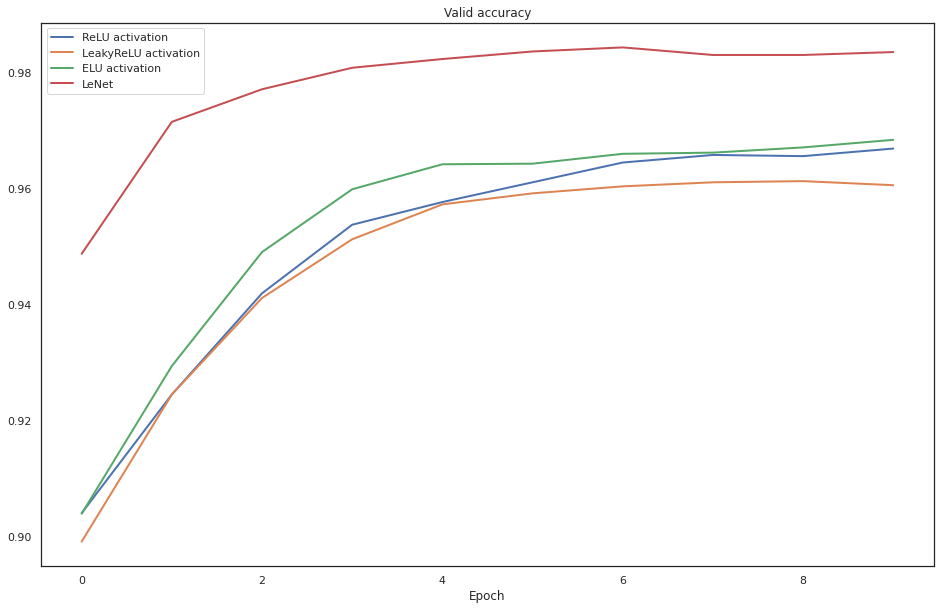

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [ ]:
lenet_accuracy[-1]

0.9834735576923077

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.98